In [112]:
import tensorflow as tf
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt

%matplotlib inline

def featureNormalise(X):
    mu = np.mean(X,0)
    sigma = np.std(X,0, ddof=1)
    return ((X - mu) / sigma), mu, sigma

def mapFeatures(x1, x2):
    degree = 6;
    out = np.ones([x1.shape[0],1]);
    for i in range(1, degree+1):
        for j in range(0, i+1):
            out = np.hstack((out,np.array((x1**(i-j)) * (x2**j)).reshape(x1.shape[0],1)))
    return out


## Load Training data
dataset = pandas.read_csv("data/ex2data2.txt", header=None)
m,n = dataset.shape
X = dataset.values[:,0:n-1].reshape(m,n-1).astype(np.float32)
y = dataset.values[:,-1].reshape(m,1).astype(np.float32)

## Load Validation and Test data

## Normalise
x_norm = X#, mu, sigma = featureNormalise(X)

# Add bias
#x_with_bias = np.hstack((np.ones((x_norm.shape[0],1)),x_norm)).astype(np.float32)
x_with_bias = mapFeatures(x_norm[:,0], x_norm[:,1]).astype(np.float32)
m,n = x_with_bias.shape

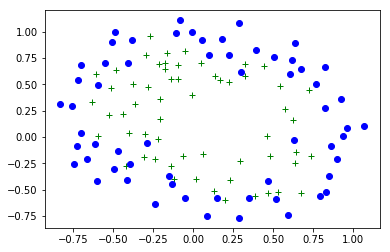

In [113]:
pos = (y==1).ravel()
neg = (y == 0).ravel()

# Plot Examples
plt.plot(X[pos,0], X[pos, 1], '+',color="green")
plt.plot(X[neg,0], X[neg, 1], 'o', color="blue");


In [114]:
import tensorflow as tf

# We'll bundle groups of examples during training for efficiency.
# This defines the size of the batch.
BATCH_SIZE = m

NUM_FEATURES = n 
NUM_LABELS = 1
# The random seed that defines initialization.
#SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_FEATURES))
train_labels_node = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized. 
# TODO : These should be pulled from a config file

weights = tf.Variable(tf.ones([n, 1]))
    
print('Done')

Done


In [115]:
def model(data, train=False):
    """The Model definition."""
    # Linear Regression

    # learning_rate is the step size, so how much we jump from the current spot
    #learning_rate = 0.01

    # The operations in the operation graph.
    # Compute the predicted y values given our current weights
    yhat = tf.sigmoid(tf.matmul(data, weights))
    
    return yhat
    
print('Done')

Done


In [116]:
yhat = model(train_data_node, True)

lam = 1.0

# Change the weights by subtracting derivative with respect to that weight
loss = (1.0 /  m) * tf.add(tf.add(tf.matmul(tf.negative(y.T), tf.log(yhat)), tf.matmul(tf.negative((1-y).T), tf.log(1-yhat))) , (lam / 2.0) * tf.matmul(tf.transpose(weights[1:,:]), weights[1:,:]))

# Optimizer: 

# Gradient Descent
yerror = tf.subtract(yhat, train_labels_node)
zero = tf.constant(np.zeros([1,1]).astype(np.float32))
gradient = (1.0 / m) * tf.add(tf.transpose(tf.matmul(tf.transpose(yerror), train_data_node)), lam * tf.concat([zero, weights[1:,:]],0))
update_weights = tf.assign_sub(weights, gradient)

# Predictions
train_prediction = yhat

print('Done')

Done


In [117]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.global_variables_initializer().run()

In [118]:
#################
##### Train #####
#################

# Keep track of the loss at each iteration so we can chart it later
losses = []
# How many iterations to run our training
training_steps = 1500


for _ in range(training_steps):
    # Feed the entire batch
    # Grab the first BATCH_SIZE examples and labels.
    batch_data = x_with_bias[:BATCH_SIZE,:]
    batch_labels = y[:BATCH_SIZE,:]
    
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    
    # Run the graph and fetch some of the nodes.
    betas, g, l, predictions = s.run(
        [update_weights, gradient, loss, train_prediction],
        feed_dict=feed_dict)
    
    # Print out the loss periodically.
    losses.append(l)

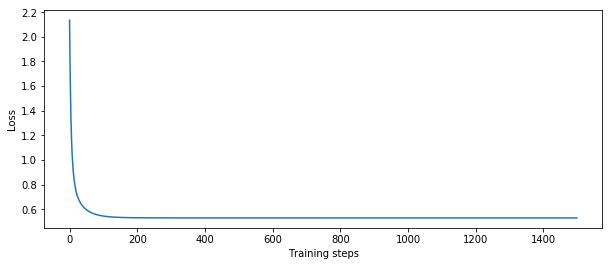

In [119]:
# Show the fit and the loss over time.
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax1.plot(range(0, training_steps), np.array(losses).ravel())
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
plt.show()

In [120]:
prediction = model(tf.constant(x_with_bias), False)

predictions = prediction.eval()
print prediction.shape
p = np.zeros([m,1])
p[predictions > .5] = 1.0
np.mean(p == y) * 100 # Accuracy on training set


(118, 1)


83.050847457627114